In [1]:
__imp

Libraries have been loaded


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display

from sklearn import metrics

In [4]:
set_plot_sizes(12,14,16)

### Load Processed Data

In [5]:
PATH = '../data/interim/dataset1/application_train.pkl'

df_raw = pd.read_pickle(PATH)
df_trn, y_trn, nas = proc_df(df_raw, 'TARGET', skip_flds=['SK_ID_CURR'])

In [6]:
def split_vals(X, y, test_size=.3):
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, stratify=y, test_size=test_size, random_state=SEED)
    
    return X_trn, X_val, y_trn, y_val

In [7]:
def print_score(m, X_tr, y_tr, X_val, y_val):
    res = [metrics.log_loss(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.log_loss(y_val, m.predict_proba(X_val)[:, 1]),
           metrics.roc_auc_score(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.roc_auc_score(y_val, m.predict_proba(X_val)[:, 1])]
    
    print(res)

In [8]:
def get_oob(df_keep, y_trn, m=None):
    X_tr, X_val, y_tr, y_val = split_vals(df_keep, y_trn)
    
    if m is None:
        m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
    
    m.fit(X_tr, y_tr)
    print_score(m, X_tr, y_tr, X_val, y_val)
    
    return m

In [9]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [10]:
# set Random Forest to consider only a sample
set_rf_samples(50000)

In [12]:
%%time

m = RandomForestClassifier(n_estimators=50, 
                           min_samples_leaf=100, 
                           max_depth=7,
                           max_features=.8, 
                           n_jobs=-1)

m = get_oob(df_trn, y_trn, m)

[0.250938644222199, 0.25366626975784085, 0.7428026320523706, 0.7319335994519671]
CPU times: user 2min, sys: 2.03 s, total: 2min 2s
Wall time: 40.4 s


### Feature Importance

In [13]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
38,EXT_SOURCE_3,0.353815
37,EXT_SOURCE_2,0.340664
36,EXT_SOURCE_1,0.059097
22,DAYS_BIRTH,0.027316
23,DAYS_EMPLOYED,0.018043
18,CODE_GENDER,0.016421
0,AMT_ANNUITY,0.015968
88,NAME_EDUCATION_TYPE,0.014408
24,DAYS_ID_PUBLISH,0.013662
101,OCCUPATION_TYPE,0.012100


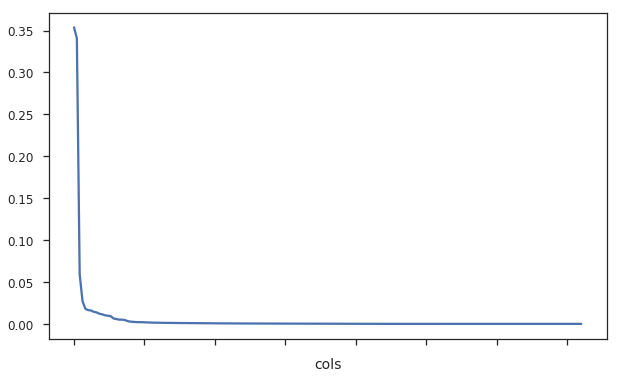

In [14]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

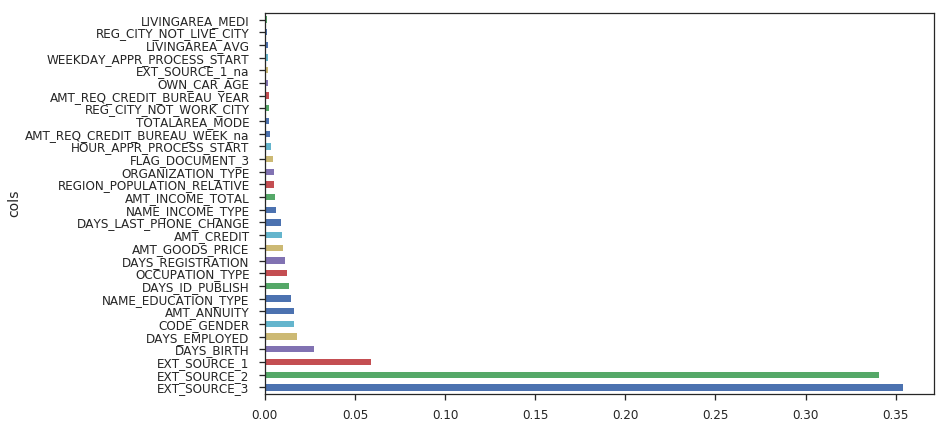

In [15]:
plot_fi(fi[:30]);

In [17]:
to_keep = fi[fi.imp>0.0005].cols; len(to_keep)

59

In [18]:
df_keep = df_trn[to_keep].copy()
m = RandomForestClassifier(n_estimators=50, 
                           min_samples_leaf=100, 
                           max_depth=7,
                           max_features=.8, 
                           n_jobs=-1)

m = get_oob(df_keep, y_trn, m)

[0.25099827520800855, 0.25356533695638467, 0.742399312728736, 0.7327951823664363]


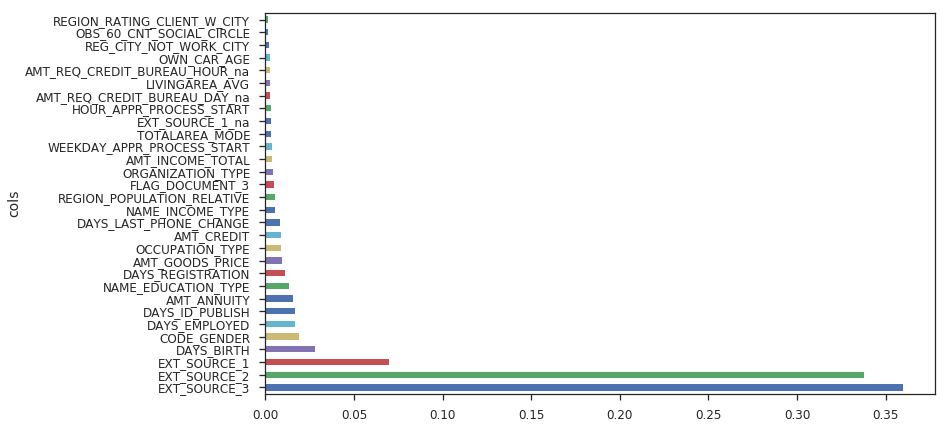

In [19]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

### Age is one of the top predictors

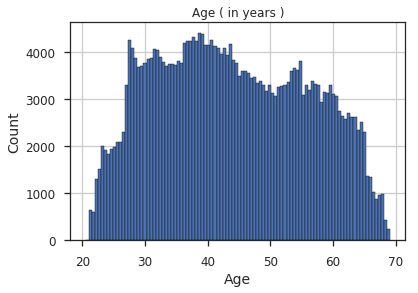

In [21]:
(-df_raw.DAYS_BIRTH / 365).hist(edgecolor='k', bins=100)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age ( in years )');

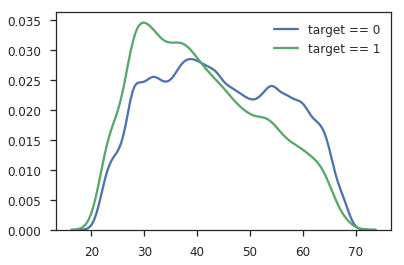

In [23]:
sns.kdeplot(-df_raw[y_trn == 0].DAYS_BIRTH / 365, label='target == 0')
sns.kdeplot(-df_raw[y_trn == 1].DAYS_BIRTH / 365, label='target == 1');

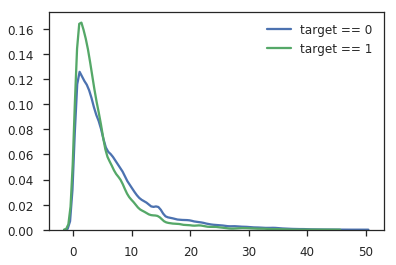

In [45]:
sns.kdeplot(-df_raw[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365, label='target == 0')
sns.kdeplot(-df_raw[y_trn == 1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365, label='target == 1');

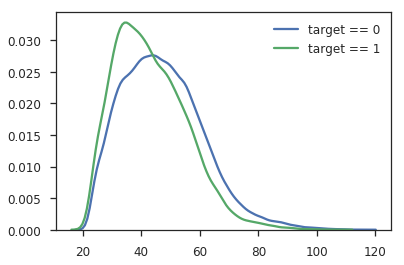

In [50]:
# Relationship bewtween age and employed

t1 = (-df_raw[y_trn==0].DAYS_BIRTH / 365) + (-df_raw[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)
t2 = (-df_raw[y_trn==1].DAYS_BIRTH / 365) + (-df_raw[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

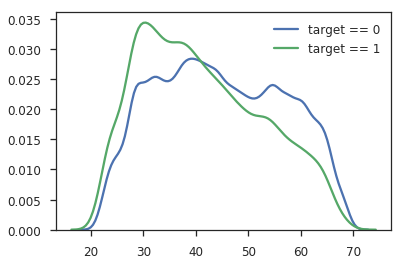

In [54]:
# Relationship between age and external scores
t1 = (-df_trn[y_trn==0].DAYS_BIRTH / 365) + (df_trn[y_trn==0].EXT_SOURCE_2)
t2 = (-df_trn[y_trn==1].DAYS_BIRTH / 365) + (df_trn[y_trn==1].EXT_SOURCE_2)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

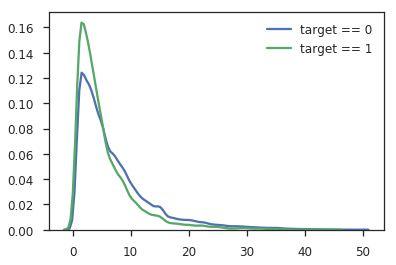

In [56]:
# Relationship between employed and external scores
t1 = (-df_trn[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365) + (df_trn[y_trn==0].EXT_SOURCE_2)
t2 = (-df_trn[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365) + (df_trn[y_trn==1].EXT_SOURCE_2)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

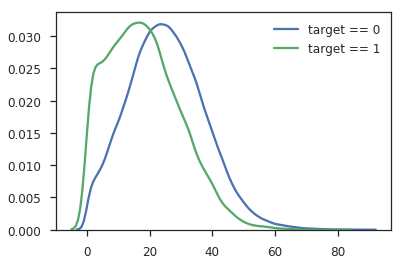

In [64]:
# Relationship bewtween age and employed

t1 = ((-df_trn[y_trn==0].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==0].EXT_SOURCE_2)

t2 = ((-df_trn[y_trn==1].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==1].EXT_SOURCE_2)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

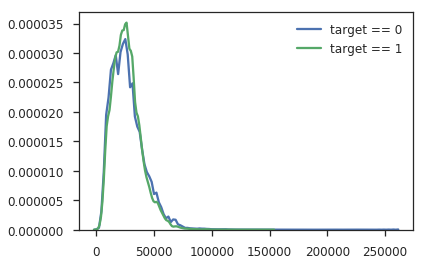

In [115]:
# annuity and target

t1 = (df_trn[y_trn==0].AMT_ANNUITY)
t2 = (df_trn[y_trn==1].AMT_ANNUITY)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

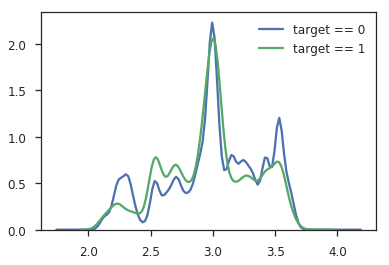

In [119]:
# annuity, income and target

t1 = (df_trn[y_trn==0].AMT_CREDIT.map(np.log1p)) - (df_trn[y_trn==0].AMT_ANNUITY.map(np.log1p))
t2 = (df_trn[y_trn==1].AMT_CREDIT.map(np.log1p)) - (df_trn[y_trn==1].AMT_ANNUITY.map(np.log1p))

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

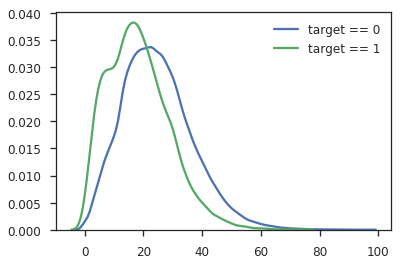

In [68]:
# Relationship bewtween age and employed

t1 = ((-df_trn[y_trn==0].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==0].EXT_SOURCE_3)

t2 = ((-df_trn[y_trn==1].DAYS_BIRTH / 365) +\
     (-df_trn[y_trn==1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365)) *\
     (df_trn[y_trn==1].EXT_SOURCE_3)

sns.kdeplot(t1, label='target == 0')
sns.kdeplot(t2, label='target == 1');

In [72]:
# Relationship with age and gender
df_trn.loc[(-df_trn.DAYS_BIRTH / 365) < 40, 'CODE_GENDER'].value_counts(normalize=True)

1    0.594199
2    0.405777
3    0.000024
Name: CODE_GENDER, dtype: float64

In [73]:
df_trn.loc[(-df_trn.DAYS_BIRTH / 365) >= 40, 'CODE_GENDER'].value_counts(normalize=True)

1    0.703655
2    0.296340
3    0.000006
Name: CODE_GENDER, dtype: float64

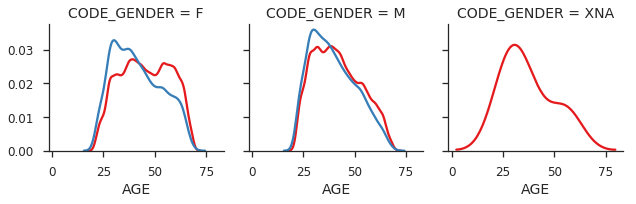

In [96]:
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_BIRTH', 'TARGET']].copy()
x.loc[:, 'AGE'] = (-x.DAYS_BIRTH / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1')
g = g.map(sns.kdeplot, 'AGE')

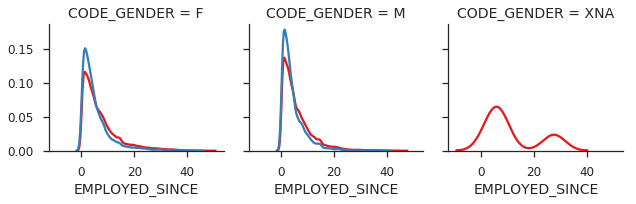

In [105]:
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_EMPLOYED', 'TARGET']].copy()
x.loc[:, 'EMPLOYED_SINCE'] = (-x.DAYS_EMPLOYED.replace({365243: np.nan}) / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1')
g = g.map(sns.kdeplot, 'EMPLOYED_SINCE')

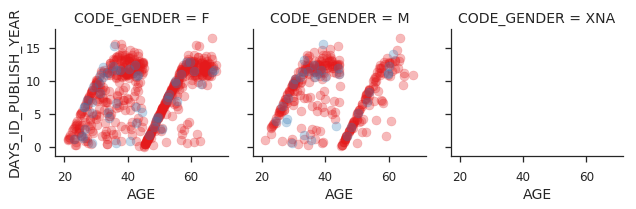

In [108]:
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'TARGET']].sample(n=1000).copy()
x.loc[:, 'AGE'] = (-x.DAYS_BIRTH / 365)
x.loc[:, 'DAYS_ID_PUBLISH_YEAR'] = (-x.DAYS_ID_PUBLISH / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1')
g = g.map(plt.scatter, 'AGE', 'DAYS_ID_PUBLISH_YEAR', alpha=.3)

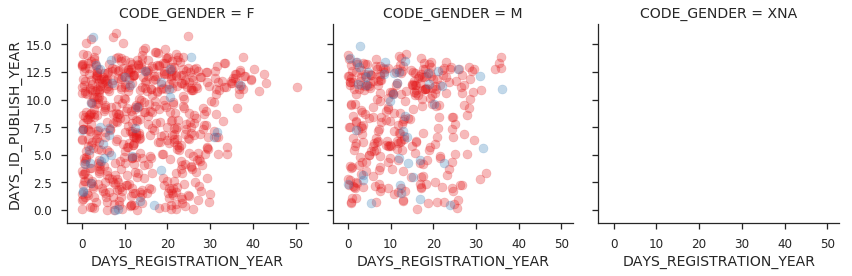

In [110]:
x = df_raw.loc[:, ['CODE_GENDER', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'TARGET']].sample(n=1000).copy()
x.loc[:, 'DAYS_REGISTRATION_YEAR'] = (-x.DAYS_REGISTRATION / 365)
x.loc[:, 'DAYS_ID_PUBLISH_YEAR']   = (-x.DAYS_ID_PUBLISH / 365)

g = sns.FacetGrid(x, 
                  col='CODE_GENDER', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4
                 )
g = g.map(plt.scatter, 'DAYS_REGISTRATION_YEAR', 'DAYS_ID_PUBLISH_YEAR', alpha=.3)

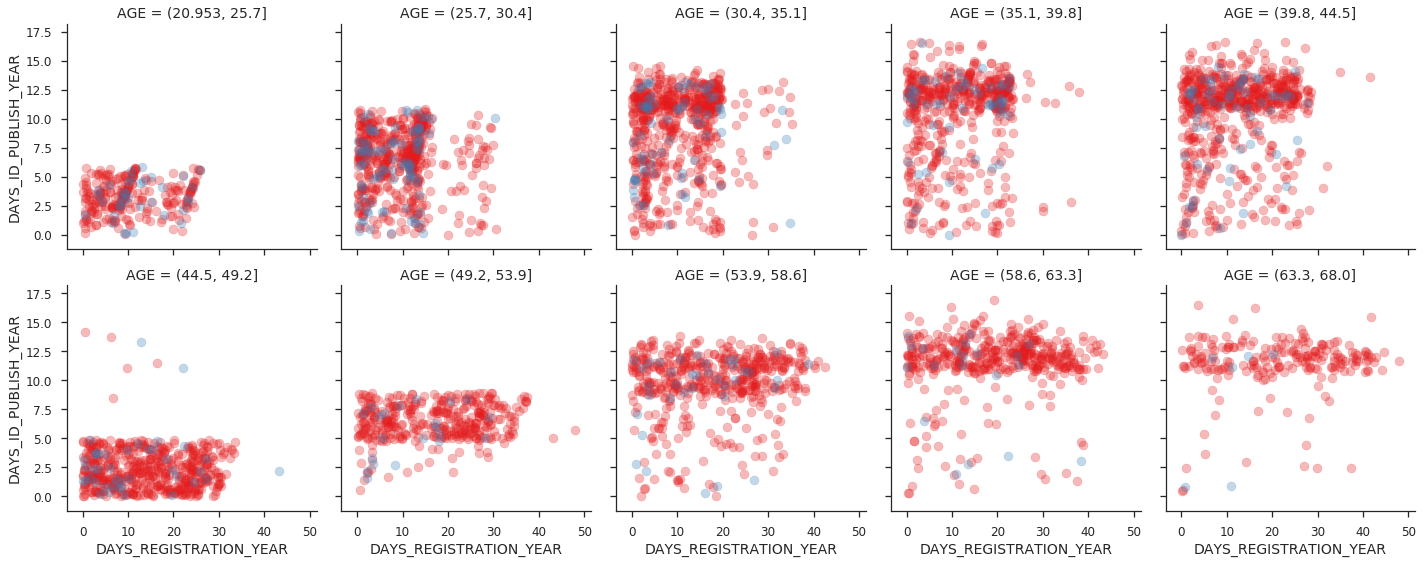

In [114]:
x = df_raw.loc[:, ['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'TARGET']].sample(n=5000).copy()
x.loc[:, 'AGE']                    = pd.cut((-x.DAYS_BIRTH / 365).astype(np.int), bins=10)
x.loc[:, 'DAYS_REGISTRATION_YEAR'] = (-x.DAYS_REGISTRATION / 365)
x.loc[:, 'DAYS_ID_PUBLISH_YEAR']   = (-x.DAYS_ID_PUBLISH / 365)

g = sns.FacetGrid(x, 
                  col='AGE', 
                  hue='TARGET', 
                  palette='Set1',
                  size=4,
                  col_wrap=5
                 )

g = g.map(plt.scatter, 'DAYS_REGISTRATION_YEAR', 'DAYS_ID_PUBLISH_YEAR', alpha=.3)

In [102]:
df_keep = df_trn.copy()a

df_keep.loc[:, 'annuity_credit'] = df_keep.AMT_CREDIT / df_keep.AMT_ANNUITY
df_keep.loc[:, 'add_ext_2_3']    = df_keep.EXT_SOURCE_2 + df_keep.EXT_SOURCE_3
df_keep.loc[:, 'mult_ext_2_3']   = df_keep.EXT_SOURCE_2 * df_keep.EXT_SOURCE_3
df_keep.loc[:, 'diff_ext_2_3']   = df_keep.EXT_SOURCE_2 - df_keep.EXT_SOURCE_3
df_keep.loc[:, 'add_ext_1_2']    = df_keep.EXT_SOURCE_1 + df_keep.EXT_SOURCE_2
df_keep.loc[:, 'ext_2_age']      = df_keep.EXT_SOURCE_2 * (-df_keep.DAYS_BIRTH / 365)
df_keep.loc[:, 'ext_3_age']      = df_keep.EXT_SOURCE_3 * (-df_keep.DAYS_BIRTH / 365)
# df_keep.loc[:, 'age_gender']     = pd.factorize((-df_keep.DAYS_BIRTH / 365).astype(np.int).astype(np.str) + '_' +\
#                                    (df_keep.CODE_GENDER.astype(np.str)))[0]

In [ ]:
m = get_oob(df_keep, y_trn) # baseline score

In [100]:
%%time

m = get_oob(df_keep, y_trn, m=RandomForestClassifier(n_estimators=50, 
                                                     min_samples_leaf=100, 
                                                     max_depth=7,
                                                     max_features=.8,
                                                     random_state=SEED, 
                                                     n_jobs=-1))

[0.24970948110841867, 0.2524572084587174, 0.7479135638423328, 0.7367509371170335]
CPU times: user 2min 17s, sys: 1.93 s, total: 2min 19s
Wall time: 43.5 s


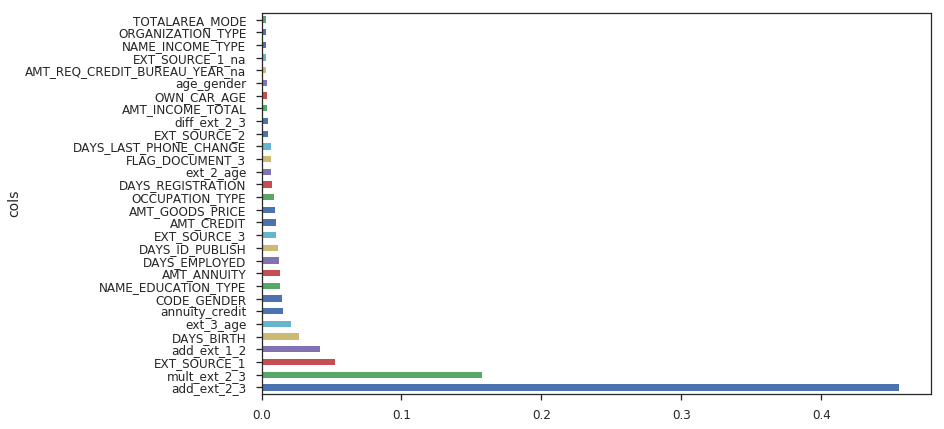

In [101]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

### Relationship between DAYS_ID_PUBLISH, DAYS_REGISTRATION and DAYS_LAST_PHONE_CHANGE

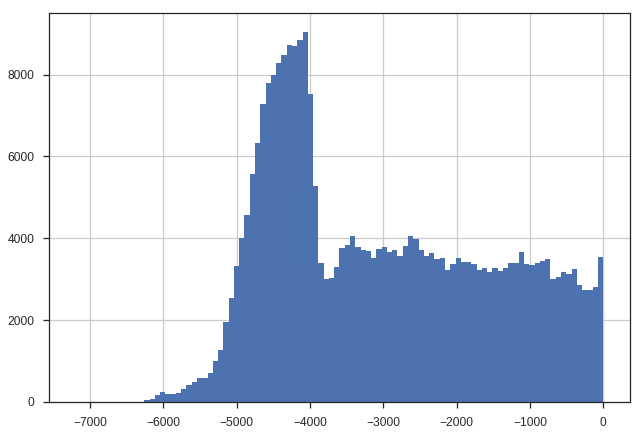

In [37]:
df_trn.DAYS_ID_PUBLISH.hist(bins=100);

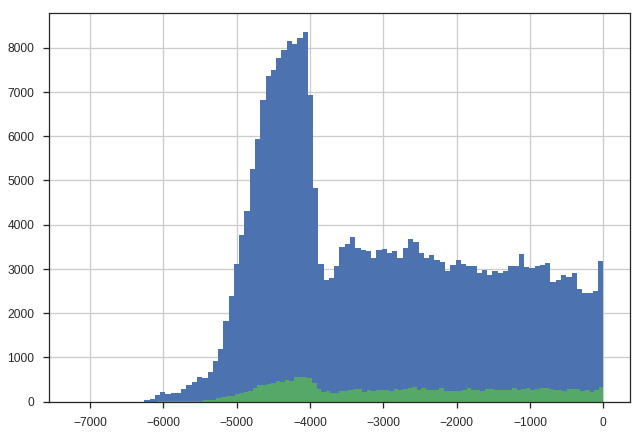

In [38]:
df_trn[y_trn==0].DAYS_ID_PUBLISH.hist(bins=100)
df_trn[y_trn==1].DAYS_ID_PUBLISH.hist(bins=100);

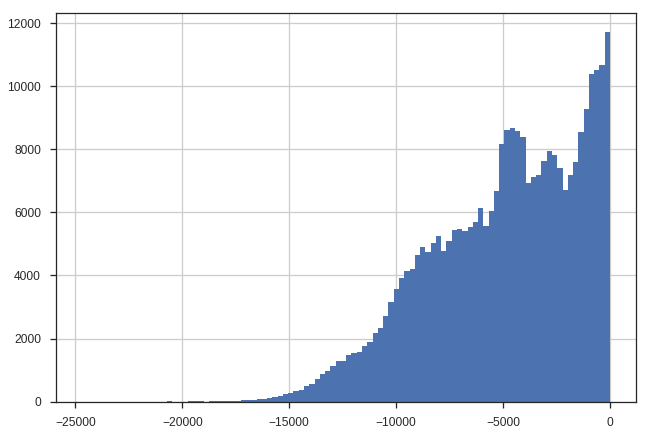

In [39]:
df_trn.DAYS_REGISTRATION.hist(bins=100);

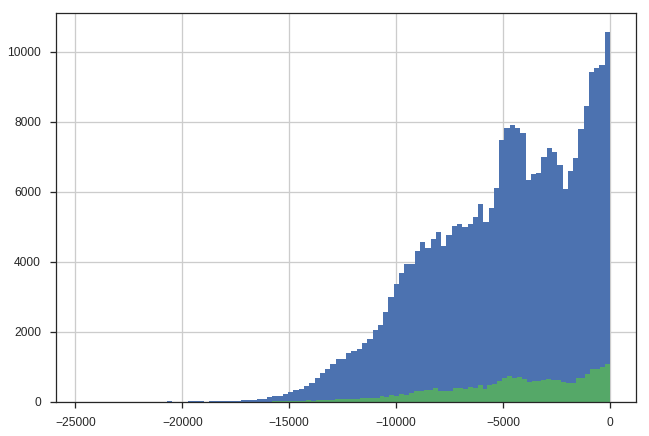

In [40]:
df_trn[y_trn==0].DAYS_REGISTRATION.hist(bins=100)
df_trn[y_trn==1].DAYS_REGISTRATION.hist(bins=100);

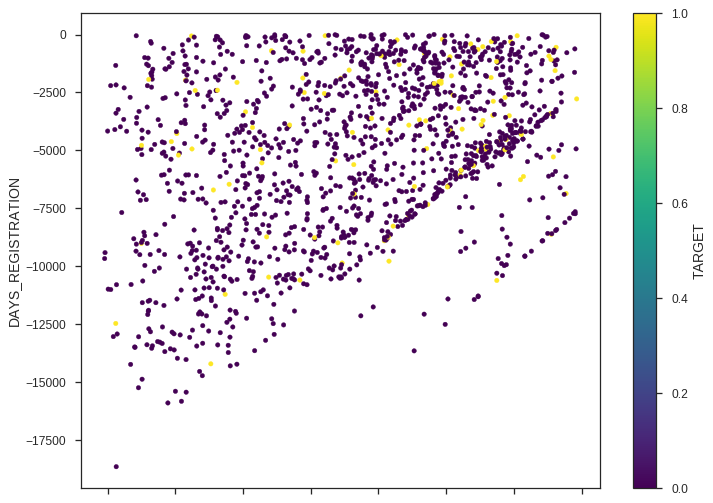

In [55]:
df_raw.sample(n=1500).plot('DAYS_BIRTH', 'DAYS_REGISTRATION', 'scatter', c='TARGET', cmap='viridis')
plt.tight_layout();

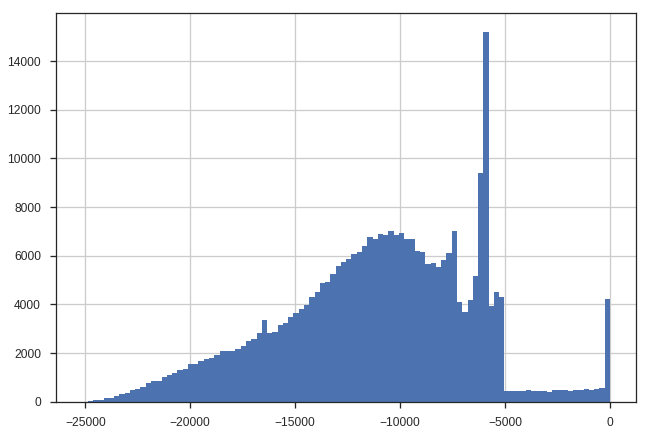

In [59]:
(df_trn.DAYS_BIRTH - df_trn.DAYS_REGISTRATION).hist(bins=100);

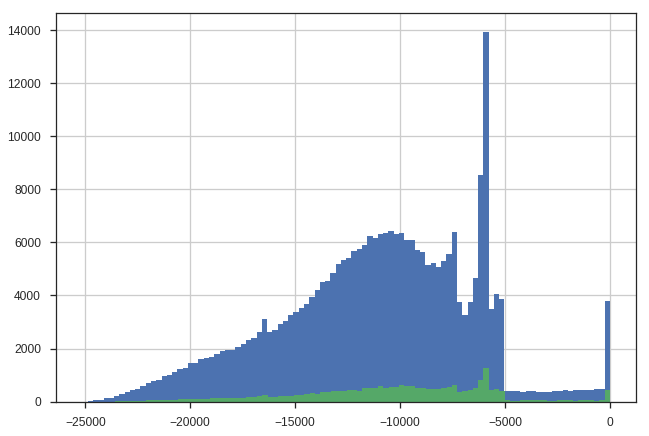

In [60]:
(df_trn.DAYS_BIRTH - df_trn.DAYS_REGISTRATION)[y_trn==0].hist(bins=100)
(df_trn.DAYS_BIRTH - df_trn.DAYS_REGISTRATION)[y_trn==1].hist(bins=100);

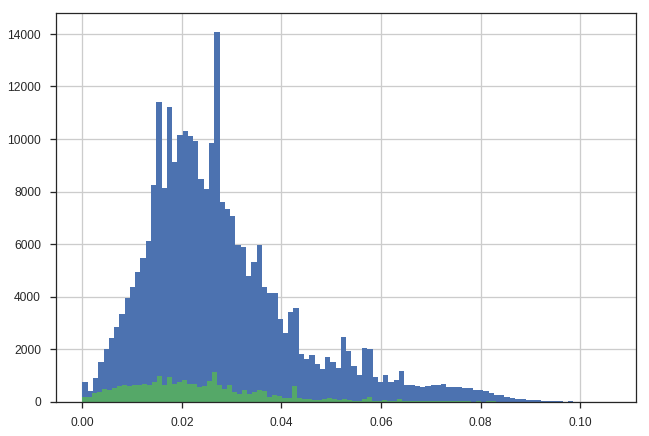

In [70]:
tmp = df_keep.AMT_ANNUITY / df_keep.AMT_CREDIT
(tmp * df_trn.EXT_SOURCE_3)[y_trn==0].hist(bins=100)
(tmp * df_trn.EXT_SOURCE_3)[y_trn==1].hist(bins=100);

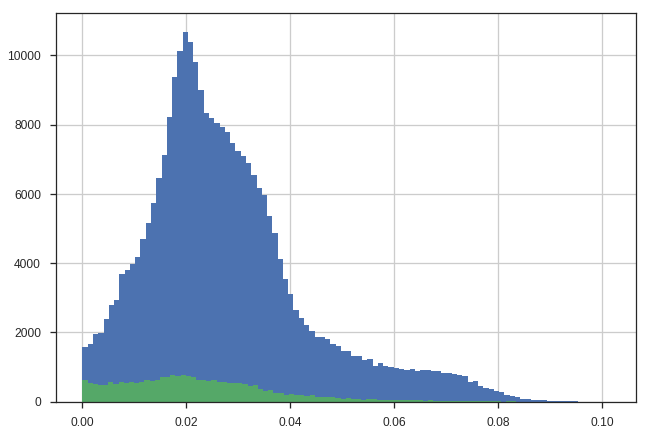

In [79]:
tmp = df_keep.AMT_ANNUITY / df_keep.AMT_CREDIT
(tmp * df_trn.EXT_SOURCE_2)[y_trn==0].hist(bins=100)
(tmp * df_trn.EXT_SOURCE_2)[y_trn==1].hist(bins=100);

In [89]:
df_keep = df_trn.copy()

df_keep.loc[:, 'annuity_credit']   = df_keep.AMT_CREDIT / df_keep.AMT_ANNUITY
df_keep.loc[:, 'add_ext_2_3']      = df_keep.EXT_SOURCE_2 + df_keep.EXT_SOURCE_3
df_keep.loc[:, 'mult_ext_2_3']     = df_keep.EXT_SOURCE_2 * df_keep.EXT_SOURCE_3
df_keep.loc[:, 'diff_ext_2_3']     = df_keep.EXT_SOURCE_2 - df_keep.EXT_SOURCE_3
df_keep.loc[:, 'add_ext_1_2']      = df_keep.EXT_SOURCE_1 + df_keep.EXT_SOURCE_2
df_keep.loc[:, 'ext_2_age']        = df_keep.EXT_SOURCE_2 * (-df_keep.DAYS_BIRTH / 365)
df_keep.loc[:, 'ext_3_age']        = df_keep.EXT_SOURCE_3 * (-df_keep.DAYS_BIRTH / 365)
df_keep.loc[:, 'mult_ext_2_ratio'] = df_keep.annuity_credit * df_keep.EXT_SOURCE_2 
df_keep.loc[:, 'add_ext_2_ratio']  = df_keep.annuity_credit + df_keep.EXT_SOURCE_2
df_keep.loc[:, 'mult_rate_age']    = df_keep.annuity_credit * (-df_keep.DAYS_BIRTH / 365)
df_keep.loc[:, 'add_rate_age']     = df_keep.annuity_credit + (-df_keep.DAYS_BIRTH / 365)

In [62]:
m = get_oob(df_keep, y_trn) # baseline score

[0.18381526911130486, 0.30152635103659153, 0.9459302346310727, 0.7029175894990811]


In [90]:
%%time

# tuned model
m = get_oob(df_keep, y_trn, m=RandomForestClassifier(n_estimators=50, 
                                                     min_samples_leaf=100, 
                                                     max_depth=7,
                                                     max_features=.8,
                                                     random_state=SEED, 
                                                     n_jobs=-1))

[0.2495839480904886, 0.2523459235198777, 0.7485093311249209, 0.7373297839970537]
CPU times: user 2min 28s, sys: 1.94 s, total: 2min 30s
Wall time: 49.4 s


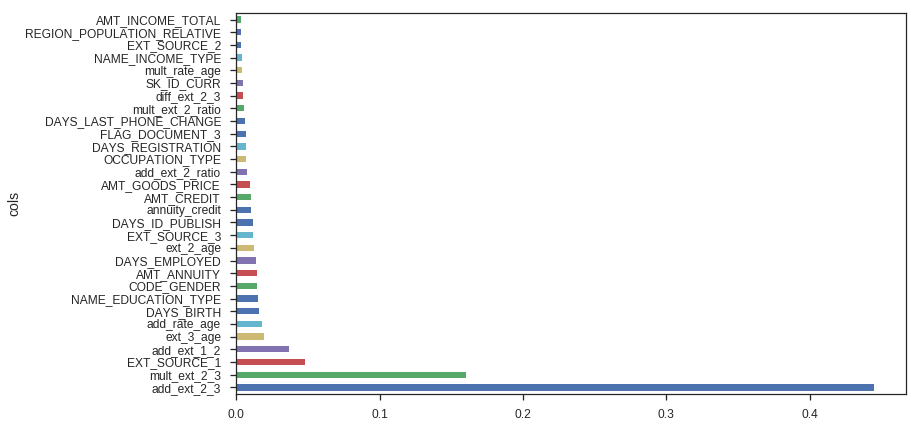

In [91]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);